   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000       

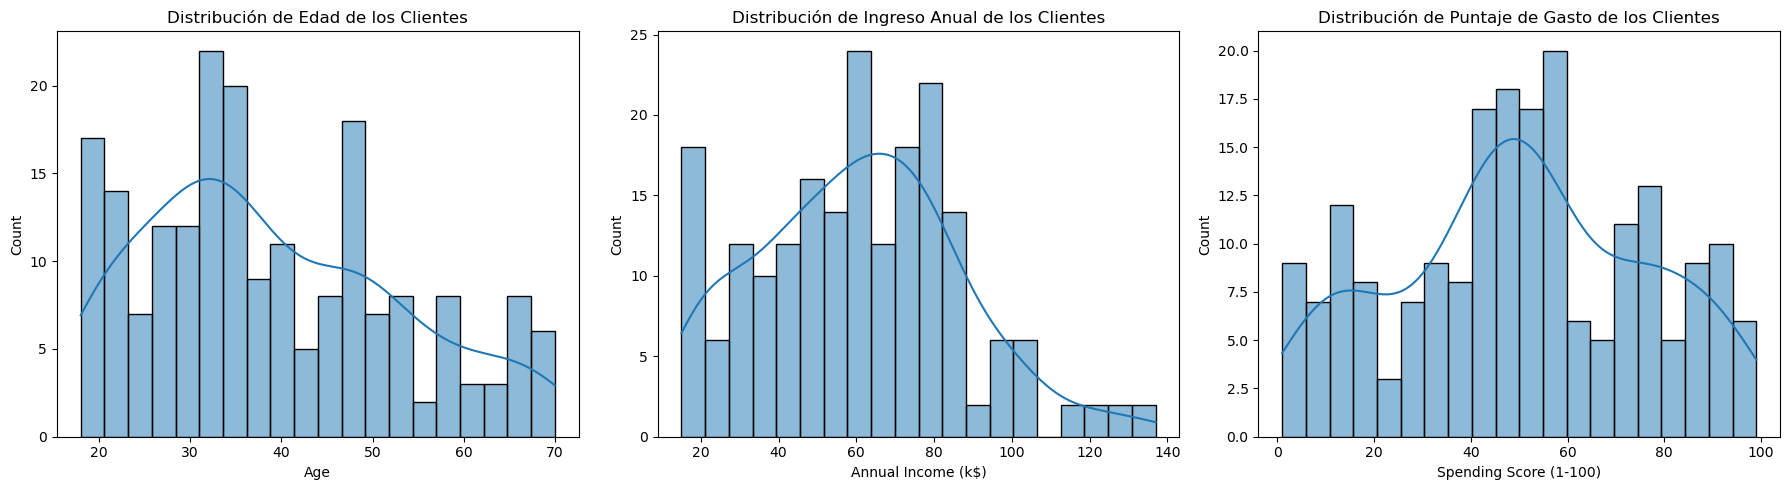

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Características seleccionadas: Index(['Gender', 'Age', 'Annual Income (k$)'], dtype='object')


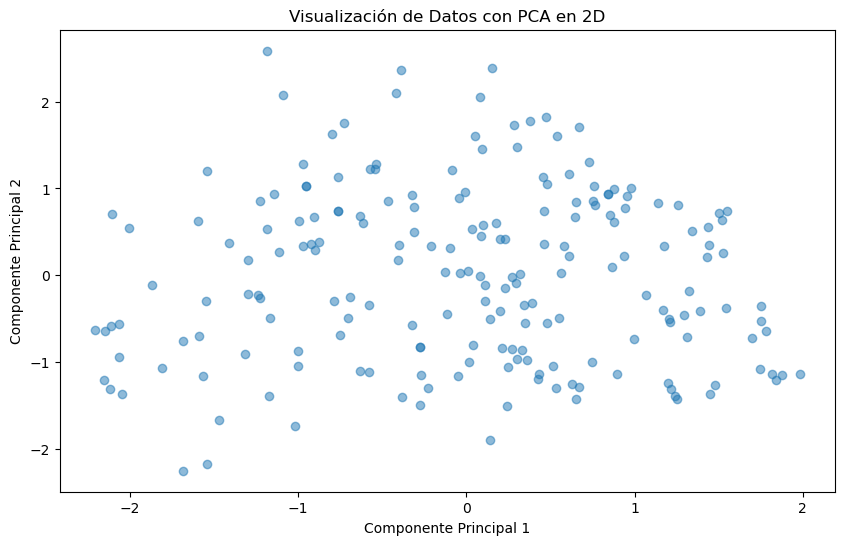

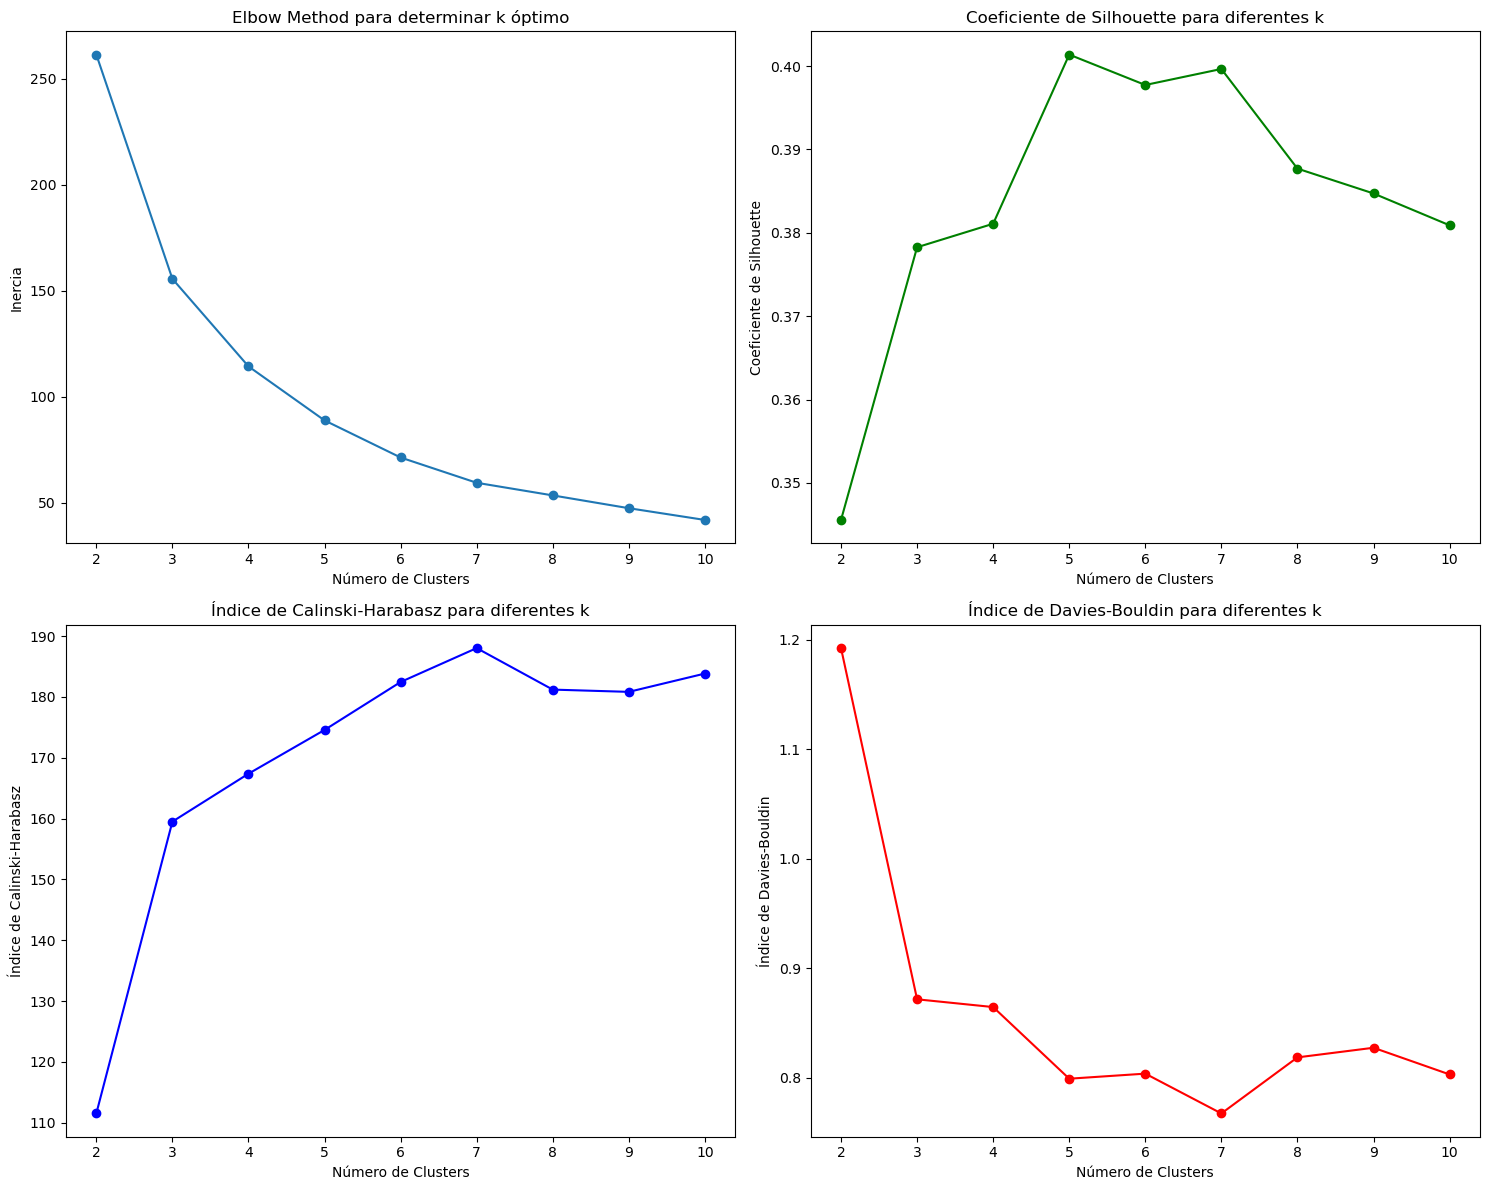

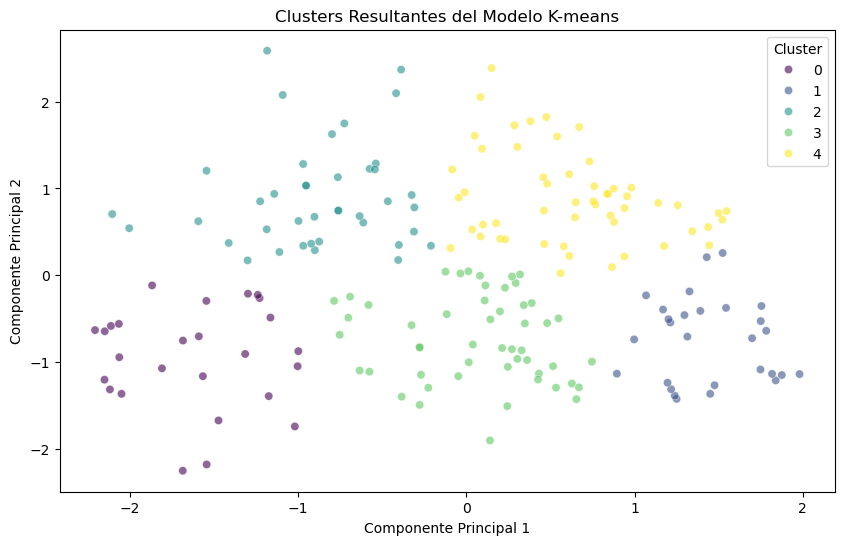

           Gender        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                 
0        0.000000  58.846154           48.692308               39.846154
1        1.000000  27.857143           31.285714               58.714286
2        0.150000  39.350000           85.400000               46.725000
3        0.627451  43.215686           42.647059               49.784314
4        0.867925  30.566038           77.452830               53.792453

Se realizaron las siguientes mejoras:
1. Se ajustaron los hiperparámetros del modelo K-means: init='k-means++', n_init=10, max_iter=300.
2. Se añadieron métricas adicionales de evaluación: índice de Davies-Bouldin.
3. Se realizó un análisis de outliers utilizando el rango intercuartílico (IQR).
4. Se utilizó SelectKBest para la selección de características relevantes.
5. Se realizó una visualización combinada de métricas de evaluación del clustering en gráficos 2x2.


In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy import stats
import os
import warnings

# Configuración para evitar múltiples advertencias
warnings.filterwarnings('ignore')

# Paso 1: Análisis exploratorio de los datos
# Carga del dataset
data = pd.read_csv('Mall_Customers.csv')

# Mostrar las primeras filas del dataset
print(data.head())

# Descripción del dataset para observar tendencias y distribuciones
print(data.describe())

# Identificación de valores nulos y tipos de datos
print(data.info())

# Visualización de la distribución de las variables relevantes con histogramas
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['Age'], kde=True, bins=20)
plt.title('Distribución de Edad de los Clientes')

plt.subplot(1, 3, 2)
sns.histplot(data['Annual Income (k$)'], kde=True, bins=20)
plt.title('Distribución de Ingreso Anual de los Clientes')

plt.subplot(1, 3, 3)
sns.histplot(data['Spending Score (1-100)'], kde=True, bins=20)
plt.title('Distribución de Puntaje de Gasto de los Clientes')

plt.tight_layout()
plt.show()

# Paso 2: Preprocesamiento de los datos
# Eliminación de columnas irrelevantes ('CustomerID')
data = data.drop(columns=['CustomerID'])

# Codificación de la variable categórica 'Gender' en valores numéricos
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

# Identificación de valores faltantes
print(data.isnull().sum())

# Análisis y eliminación de outliers utilizando el rango intercuartílico (IQR)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Paso 3: Selección de Características
# Selección de características utilizando SelectKBest
X = data.drop(columns=['Spending Score (1-100)'])
y = data['Spending Score (1-100)']
selector = SelectKBest(score_func=f_classif, k=3)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Características seleccionadas: {selected_features}")

# Escalado de las variables numéricas
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X_new)

# Paso 4: Reducción de Dimensionalidad con PCA
# Aplicación de PCA para reducir la dimensionalidad a 2 componentes
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Visualización de los resultados de PCA en 2D
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Datos con PCA en 2D')
plt.show()

# Paso 5: Entrenamiento del modelo K-means
# Ajuste de la variable de entorno para evitar problemas de fuga de memoria en Windows con MKL
os.environ['OMP_NUM_THREADS'] = '1'

# Inicialización del modelo con diferentes números de clusters para identificar el óptimo
inertia = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
range_clusters = range(2, 11)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10, max_iter=300)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(data_pca, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(data_pca, labels))
    davies_bouldin_scores.append(davies_bouldin_score(data_pca, labels))

# Gráficos combinados para evaluar las diferentes métricas de clustering
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0, 0].plot(range_clusters, inertia, marker='o')
axes[0, 0].set_xlabel('Número de Clusters')
axes[0, 0].set_ylabel('Inercia')
axes[0, 0].set_title('Elbow Method para determinar k óptimo')

axes[0, 1].plot(range_clusters, silhouette_scores, marker='o', color='green')
axes[0, 1].set_xlabel('Número de Clusters')
axes[0, 1].set_ylabel('Coeficiente de Silhouette')
axes[0, 1].set_title('Coeficiente de Silhouette para diferentes k')

axes[1, 0].plot(range_clusters, calinski_harabasz_scores, marker='o', color='blue')
axes[1, 0].set_xlabel('Número de Clusters')
axes[1, 0].set_ylabel('Índice de Calinski-Harabasz')
axes[1, 0].set_title('Índice de Calinski-Harabasz para diferentes k')

axes[1, 1].plot(range_clusters, davies_bouldin_scores, marker='o', color='red')
axes[1, 1].set_xlabel('Número de Clusters')
axes[1, 1].set_ylabel('Índice de Davies-Bouldin')
axes[1, 1].set_title('Índice de Davies-Bouldin para diferentes k')

plt.tight_layout()
plt.show()

# Paso 6: Selección del número óptimo de clusters
# Selección del número óptimo de clusters basado en las gráficas anteriores
optimal_k = 5

# Entrenamiento del modelo K-means con el número óptimo de clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++', n_init=10, max_iter=300)
kmeans_final.fit(data_pca)

# Agregar las etiquetas de cluster al dataframe original
data['Cluster'] = kmeans_final.labels_

# Visualización de los clusters resultantes en PCA reducido a 2D
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis', alpha=0.6)
plt.title('Clusters Resultantes del Modelo K-means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

# Paso 7: Interpretación de los clusters
# Cálculo de estadísticas descriptivas para cada cluster
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)

# Resumen de mejoras aplicadas
print("\nSe realizaron las siguientes mejoras:")
print("1. Se ajustaron los hiperparámetros del modelo K-means: init='k-means++', n_init=10, max_iter=300.")
print("2. Se añadieron métricas adicionales de evaluación: índice de Davies-Bouldin.")
print("3. Se realizó un análisis de outliers utilizando el rango intercuartílico (IQR).")
print("4. Se utilizó SelectKBest para la selección de características relevantes.")
print("5. Se realizó una visualización combinada de métricas de evaluación del clustering en gráficos 2x2.")
